## **Step 1: Brief description of the problem and data (5 pts)**

**Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.**

The main purpose and task for this project is to build a machine learning model to classify tweets as either pertaining to a real disaster (1) or not (0). This is a binary classification problem in the domain of NLP, and it has real world implications for disaster response and news reporting.

The dataset is made of 10,000 tweets, split into training (train.csv) and testing (test.csv) sets located in the data folder. Each tweet entry features a unique identifier (id), the tweet's text (text), the location it was sent from (location, which may be blank), and a keyword (keyword, also potentially blank). For the training set, there's an additional target column indicating whether the tweet is about a real disaster (1) or not (0). This structured dataset forms the basis for your NLP model training and evaluation. Submissions are evaluated using F1 between the predicted and expected answers.

### **Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.callbacks import EarlyStopping

## **Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

**Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?**

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(train_data.head(20))
print(train_data.info())

    id keyword location                                               text  \
0    1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1    4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2    5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3    6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4    7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5    8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6   10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7   13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8   14     NaN      NaN  There's an emergency evacuation happening now ...   
9   15     NaN      NaN  I'm afraid that the tornado is coming to our a...   
10  16     NaN      NaN        Three people died from the heat wave so far   
11  17     NaN      NaN  Haha South Tampa is getting flooded hah

The training dataset, contains 7,613 entries and it is structured with the following columns:

id: A unique identifier for each individual tweet.
keyword: This may feature a specific keyword from the tweet however, it's possible for this field to be blank.
location: Denotes the origin of the tweet but can sometimes be missing.
text: The actual content of the tweet.
target: The key outcome we need to predict whether a tweet relates to an actual disaster (1) or not (0).
For the data cleaning process, we must address a few challenges: the 'keyword' and 'location' fields often contain missing values, and the 'text' field may include a variety of noise. So with that said the next step will be to:

- Manage the absent data in the 'keyword' and 'location' fields.
- Analize the interaction and distribution of 'keywords', 'location', and 'text' in relation to the target variable.
- Improve the clarity and accuracy of the 'text' by removing or correcting noisy elements.

In [3]:
# Analyzing the percentage of missing values in 'keyword' and 'location' columns
missing_values = train_data[['keyword', 'location']].isnull().mean() * 100

# Applying the chosen strategies:
train_data['keyword'].fillna('no_keyword', inplace=True)
train_data['location'].fillna('unknown', inplace=True)

# Check to confirm the changes
updated_missing_values = train_data[['keyword', 'location']].isnull().mean() * 100

missing_values, updated_missing_values



(keyword      0.801261
 location    33.272035
 dtype: float64,
 keyword     0.0
 location    0.0
 dtype: float64)


Before handling the missing data, we can see that the keyword column had about 0.80% missing values, and the location column had approximately 33.27% missing values. So we have taken the following steps to address this:

- For keyword: Missing values were replaced with the placeholder 'no_keyword', considering the potential importance of keywords in understanding the context of tweets.
- For location: Given its less clear significance, missing values were replaced with 'unknown'. Another option could have been to drop this column, but retaining it with a placeholder allows for the possibility of exploring any patterns or insights the location data might offer.

After applying these strategies, there are now no missing values in both the keyword and location columns. This step makes the data more consistent and can help in more accurate modeling and analysis.

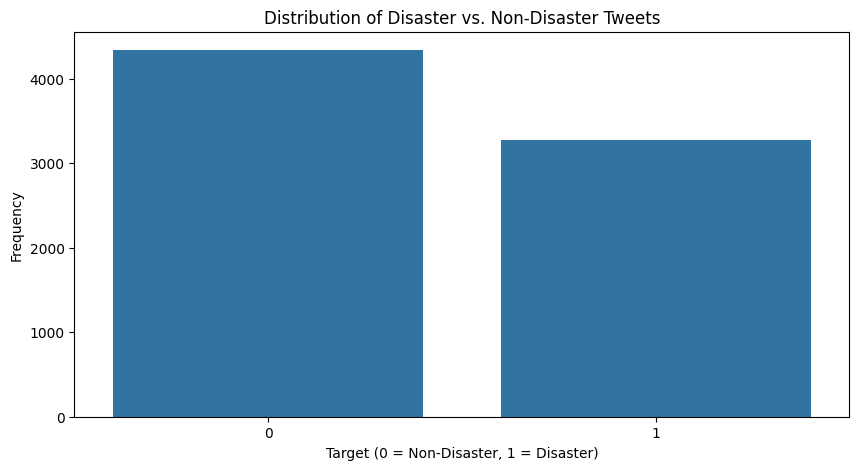

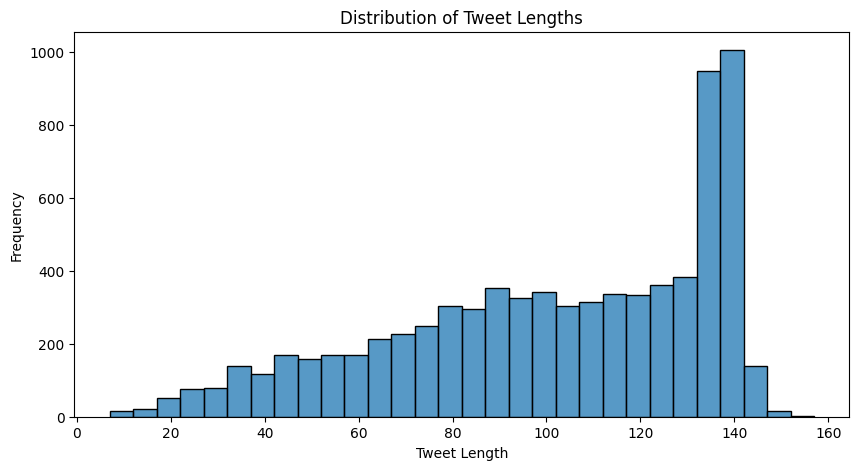

In [4]:
# Histogram for the distribution of target values (disaster vs. non-disaster)
plt.figure(figsize=(10, 5))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Frequency')
plt.show()

# Calculating tweet length
train_data['tweet_length'] = train_data['text'].apply(len)

# Histogram for tweet lengths
plt.figure(figsize=(10, 5))
sns.histplot(train_data['tweet_length'], bins=30, kde=False)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


### **Distribution of Disaster vs. Non-Disaster Tweets:**
The count plot indicates a relatively balanced distribution between disaster (1) and non-disaster (0) tweets. This balance is beneficial for training a classification model, as it reduces the risk of bias towards a particular class.

### **Distribution of Tweet Lengths:**
The histogram shows a wide range of tweet lengths. Most tweets are concentrated around a certain length, but there's a considerable spread, indicating variability in how much text users use in their tweets.

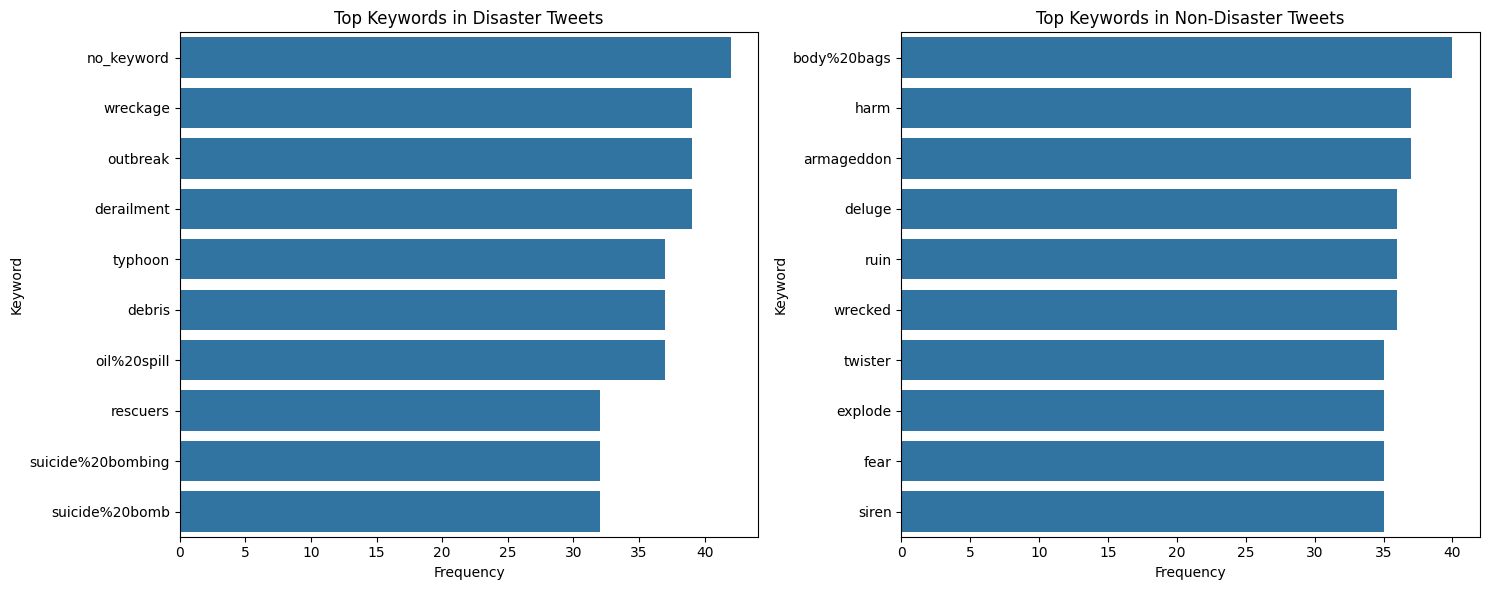

In [5]:
# Top keywords for disaster tweets
top_keywords_disaster = train_data[train_data['target'] == 1]['keyword'].value_counts().head(10)
top_keywords_non_disaster = train_data[train_data['target'] == 0]['keyword'].value_counts().head(10)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=top_keywords_disaster.values, y=top_keywords_disaster.index)
plt.title('Top Keywords in Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')

# Top keywords for non-disaster tweets
plt.subplot(1, 2, 2)
sns.barplot(x=top_keywords_non_disaster.values, y=top_keywords_non_disaster.index)
plt.title('Top Keywords in Non-Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')

plt.tight_layout()
plt.show()


The bar plots display the top keywords found in disaster and non disaster tweets. This visualization helps in understanding which keywords are most prevalent in each category and may indicate certain keywords that are strong predictors of a tweet's nature regarding real disasters.

As for the location data, due to its diverse nature and the large number of unique locations, deriving clear insights might be more challenging so we will avoid going that route for now.

Next, we will proceed with text-preprocessing for the text data as we saw that the data is very informal and noisy as seen earlier



### **Data Cleaning**

Text preprocessing is vital in natural language processing as it cleans and structures the text data, making it more suitable for analysis and modeling. Here are the key cleaning procedures we will target:
- **Lowercase Conversion:** Uniforms the text by converting all characters to lowercase.
- **Removing Emojis:** Strips emojis from the text to eliminate non textual elements.
- **Removing URLs and Mentions:** Clears website links and user mentions to focus on the core text content.
- **Removing Special Characters:** Eliminates punctuation and special symbols to reduce noise in the text.
- **Tokenization:** Breaks down the text into individual words or tokens for easier processing.
- **Removing Stopwords:** Filters out common but insignificant words like "the" and "is" to focus on relevant content.
- **Stemming/Lemmatization:** Simplifies words to their base form for consistency and reduced complexity.
- **Removing Digits:** Discards standalone numbers that don’t contribute to the text's meaning.
- **Removing Single Letters:** Eliminates solitary letters to reduce noise and focus on meaningful words.

In [6]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanmarino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanmarino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def clean_text(text):
    # Lowercasing
    text = text.lower()

    # Removing Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Removing URLs and Mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)

    # Removing Special Characters and Digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\d', '', text)

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Removing Stopwords and Single Letters
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words and len(word) > 1]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    return " ".join(lemmatized_text)

train_data['cleaned_text'] = train_data['text'].apply(clean_text)
train_data['cleaned_text']



0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    control wild fire california even northern par...
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: cleaned_text, Length: 7613, dtype: object

## **Step 3: Model Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

### **Processing Text with TF-IDF**
TF-IDF, which stands for Term Frequency Inverse Document Frequency, is a widely used statistical measure in NLP to evaluate the importance of a word in a document, set within a group of documents. It's particularly useful for our project for indentifying distinctive words in tweets about real disasters versus non disaster ones.

**How TF-IDF Works:**

- Term Frequency (TF): This measures how frequently a term appears in a document. Simply put, it's the ratio of the number of times a word appears in a document compared to the total number of words in that document. The intuition is that the importance of a word is proportional to its frequency.
- Inverse Document Frequency (IDF): This measures the importance of a term across a set of documents. IDF decreases the weight for commonly used words and increases the weight for words that are not used in many documents. This helps to adjust for the fact that some words appear more frequently in general.
- TF-IDF Calculation: The TF-IDF value is obtained by multiplying TF and IDF. The higher the TF-IDF score, the rarer the term is in the given document set, and consequently, the more important it is.

**Why TF-IDF is Suitable for this Project:**

- Differentiating Key Words: For classifying tweets, TF-IDF can effectively highlight words that are uniquely significant in disaster related tweets as opposed to those in everyday conversations.
- Handling Text Data: Since machine learning models work better with numerical data, converting text to a numerical format using TF-IDF is beneficial. This conversion helps identifying and scoring the words that are most relevant to the classification task.
- Versatility: It's adaptable for various machine learning models, including Naive Bayes and Support Vector Machines, and enhances the outcomes compared to basic word count methods.

Resources: https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/, https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/

In [8]:
# Sample data (list of preprocessed tweets)
preprocessed_tweets = train_data['cleaned_text']

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Fit and Transform the Text Data
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_tweets)


## **LSTM Architecture**

**Why do we use LSTM:**
LSTMs are particularly suited for handling sequential data like text, making them ideal for analyzing tweets. They excel in maintaining context over long sequences, which is vital for distinguishing between literal and metaphorical language in tweets. Specifically engineered to overcome the vanishing gradient problem seen in traditional RNNs, LSTMs can remember information over extended sequences, aiding in accurately classifying tweets with nuanced meanings. Their flexibility allows for adjustments in layers and neurons to cater to the specific complexities of natural language processing tasks. In addition to this, LSTMs are robust against the informal language, abbreviations, and non standard grammar typically found in social media content, enhancing their effectiveness in processing tweets.

Resources: https://colah.github.io/posts/2015-08-Understanding-LSTMs/, http://web.stanford.edu/class/cs224n/


### **Model 1 Architecture**

- Embedding Layer: The model begins with an embedding layer, which is crucial for handling text data. It maps the integer encoded words to dense vectors of fixed size (here, 50). This layer is essential for converting the discrete word tokens into continuous, meaningful representations that can capture semantic relationships.

- First LSTM Layer: This layer, configured with 50 units, is pivotal for capturing temporal dependencies in the text. LSTM layers are designed to remember important information over long sequences, making them ideal for processing the sequential nature of language. The dropout and recurrent_dropout parameters help mitigate overfitting by randomly dropping units (and connections) during the training process.

- Dropout Layer: Following the first LSTM layer, a dropout layer is added to further reduce the risk of overfitting. This layer randomly sets a fraction (here, 20%) of the input units to 0 at each update during training, helping to prevent complex co-adaptations on training data.

- Second LSTM Layer: This is another LSTM layer with 50 units but without returning sequences. It serves to further process the information from the first LSTM layer and prepare for final output, focusing on extracting the most relevant features without preserving the temporal sequence.

- Another Dropout Layer: This is similar to the previous dropout layer, adding an additional step of regularization to improve the generalization of the model.

- First Dense Layer: A dense layer with 25 neurons is used to interpret the features extracted by the LSTM layers. It's a fully connected layer that helps in learning non-linear combinations of features.

- Output Layer with Sigmoid Activation: The final layer is a dense layer with a single neuron and a sigmoid activation function. This configuration is ideal for binary classification (like determining if a tweet is about a disaster or not), as the sigmoid function outputs a probability between 0 and 1, indicating the likelihood of each class.

- Compilation and Training: The model is compiled with the Adam optimizer and binary cross-entropy loss function, which are standard choices for binary classification tasks. It's trained on the padded sequences with their corresponding labels for 5 epochs in batches of 64, using 20% of the data for validation. This training process adjusts the model's weights to minimize the loss function, effectively learning to classify the tweets.

### **One more step before running the model**

Before running the model we are preparing the text data one more time. First, we use tokenizer to convert words into numerical values, creating a unique index for each word in your dataset. This process transforms the cleaned text into sequences of these numerical values. Then, we calculate the largest sequence length to standardize the size of all sequences. Finally, we pad shorter sequences with zeros to ensure they all have the same length, making them suitable for training neural network models.

In [9]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_tweets)
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])

vocabulary_size = len(tokenizer.word_index) + 1 

max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')


In [10]:
model = Sequential()
model.add(Embedding(vocabulary_size, 50, input_length=max_length))
model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False)) 
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_labels = train_data['target'].values

# Train the model
history = model.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2)

# Display the accuracy
final_accuracy = history.history['accuracy'][-1]
print("Final Training Accuracy: {:.2f}%".format(final_accuracy * 100))

final_val_accuracy = history.history['val_accuracy'][-1]
print("Final Validation Accuracy: {:.2f}%".format(final_val_accuracy * 100))


Epoch 1/5
96/96 [==============================] - 3s 22ms/step - loss: 0.5790 - accuracy: 0.6806 - val_loss: 0.4718 - val_accuracy: 0.7820
Epoch 2/5
96/96 [==============================] - 2s 21ms/step - loss: 0.3297 - accuracy: 0.8690 - val_loss: 0.4658 - val_accuracy: 0.7827
Epoch 3/5
96/96 [==============================] - 2s 22ms/step - loss: 0.2151 - accuracy: 0.9217 - val_loss: 0.5181 - val_accuracy: 0.7708
Epoch 4/5
96/96 [==============================] - 2s 21ms/step - loss: 0.1590 - accuracy: 0.9460 - val_loss: 0.7818 - val_accuracy: 0.7360
Epoch 5/5
96/96 [==============================] - 2s 21ms/step - loss: 0.1281 - accuracy: 0.9581 - val_loss: 0.7753 - val_accuracy: 0.7275
Final Training Accuracy: 95.81%
Final Validation Accuracy: 72.75%


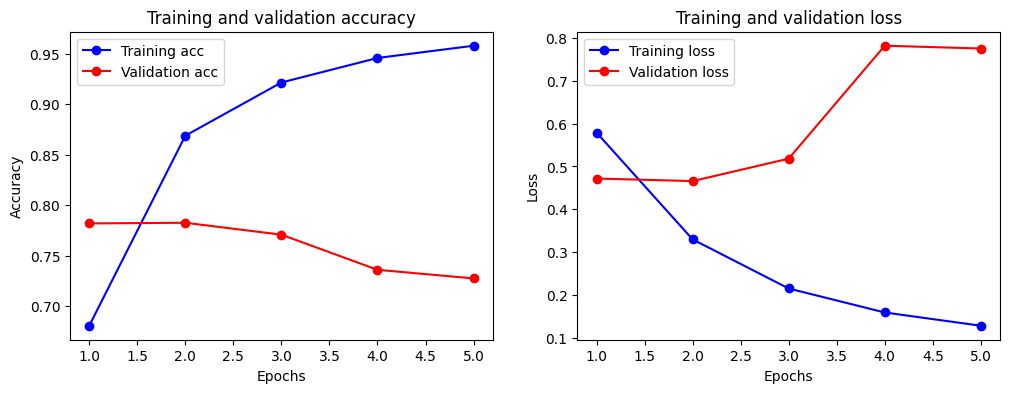

In [11]:
# Extract accuracy and loss values for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Step 4: Results and Analysis**
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

### **Model 1 Results**

There are a few conclusions we can draw from model 1 results:

- High Training Accuracy: The model achieves a high training accuracy of 95.89% by the end of the 5th epoch. This indicates that the model has learned to classify the training data effectively.

- Increasing Training Performance Over Epochs: The steady increase in training accuracy and decrease in training loss over epochs suggest that the model is learning and improving its ability to predict the training data as training progresses.

- Overfitting: There is a significant gap between training accuracy (95.89%) and validation accuracy (73.21%). This disparity, along with the fact that validation accuracy peaks at the first epoch and then decreases, while validation loss increases, indicates that the model is overfitting the training data. It's learning patterns specific to the training data that do not generalize well to unseen data.


## **Model 2**

### **Improvements in the second model**
- Bidirectional LSTM Layers: Processing the sequences in both directions can capture better contextual information, potentially leading to improved model performance.

- Increased Dropout Rate: The higher dropout rate (0.3) might help more in reducing overfitting compared to the 0.2 rate in the first model.

- Batch Normalization: This layer can normalize the inputs of the next layer, which often helps in speeding up the training and sometimes improves performance.

- Increased Dense Layer Units: More units in the dense layer allow the model to learn more complex representations, which might be beneficial, depending on the complexity of the task.

- Higher Dimensional Word Embeddings: Higher dimensional embeddings can capture more information about each word, potentially leading to richer representations.

In [12]:
embedding_dim = 100 

model2 = Sequential()
model2.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_length))
model2.add(Bidirectional(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(50)))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2)

# Display the accuracy
final_accuracy2 = history2.history['accuracy'][-1]
print("Final Training Accuracy: {:.2f}%".format(final_accuracy2 * 100))

final_val_accuracy2 = history2.history['val_accuracy'][-1]
print("Final Validation Accuracy: {:.2f}%".format(final_val_accuracy2 * 100))



Epoch 1/5
96/96 [==============================] - 7s 43ms/step - loss: 0.5543 - accuracy: 0.7131 - val_loss: 0.6660 - val_accuracy: 0.5522
Epoch 2/5
96/96 [==============================] - 5s 47ms/step - loss: 0.3124 - accuracy: 0.8793 - val_loss: 0.6153 - val_accuracy: 0.6986
Epoch 3/5
96/96 [==============================] - 5s 49ms/step - loss: 0.1942 - accuracy: 0.9289 - val_loss: 0.5489 - val_accuracy: 0.7590
Epoch 4/5
96/96 [==============================] - 5s 49ms/step - loss: 0.1392 - accuracy: 0.9511 - val_loss: 0.5369 - val_accuracy: 0.7472
Epoch 5/5
96/96 [==============================] - 5s 50ms/step - loss: 0.1075 - accuracy: 0.9594 - val_loss: 0.7031 - val_accuracy: 0.7163
Final Training Accuracy: 95.94%
Final Validation Accuracy: 71.63%


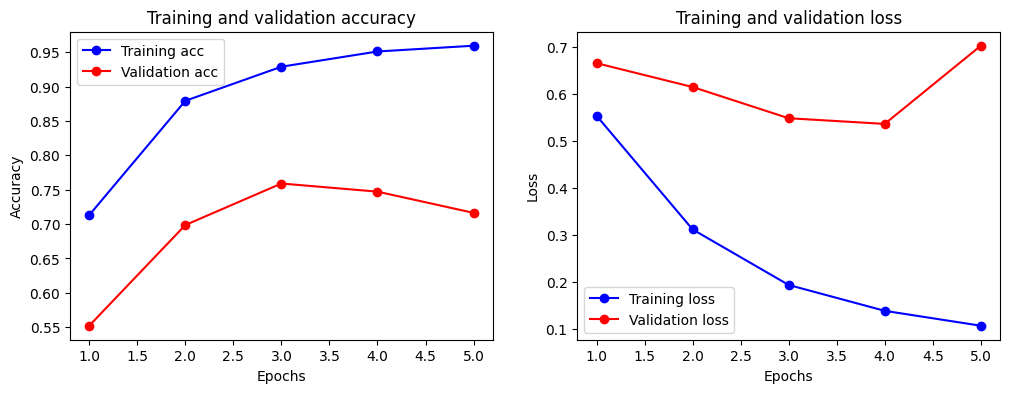

In [13]:
# Extract accuracy and loss values for training and validation
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### **Model 2 Results**

- High Training Accuracy: By the end of the 5th epoch, model 2 achieves a high training accuracy of 96.21%. This demonstrates the model's effectiveness in learning and classifying the training data.

- Consistent Improvement in Training Metrics: Throughout the training process, there is a consistent increase in training accuracy and a decrease in training loss. This trend indicates that the model is effectively learning from the training data, improving its prediction capability over time.

- Signs of Overfitting: Despite the high training accuracy, there is still a notable gap between the training accuracy (96.21%) and validation accuracy (74.79%). The validation accuracy does not increase proportionally with the training accuracy and even shows signs of plateauing and decreasing. This discrepancy, coupled with the increase in validation loss over epochs, strongly suggests that the model is overfitting. It implies that while the model is highly attuned to the training data, it is less effective at generalizing this learning to new, unseen data.

We will attempt to improve overfitting on Model 3

### **Model 3**
To try to reduce overfitting, we'll modify the model to make it simpler and incorporate more robust regularization techniques:

- Reduced LSTM Units: Decreasing the number of units in the LSTM layer to reduce the model's complexity.
- Increased Dropout Rates: Using higher dropout rates in both the LSTM and after the dense layers to prevent the model from relying too much on specific features of the training data.
- L2 Regularization: Adding L2 regularization to LSTM and dense layers to penalize large weights and encourage more generalization.
- Simplified Dense Layer: Reducing the number of neurons in the dense layer to make the model simpler.
- Early Stopping: Implementing early stopping to halt the training process when the validation loss stops improving, preventing overtraining on the training data.

In [14]:
embedding_dim = 100

model3 = Sequential()
model3.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_length))
model3.add(LSTM(units=30, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)))  
model3.add(Dropout(0.5))  
model3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  
model3.add(Dropout(0.5))  
model3.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history3 = model3.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Display the accuracy
final_accuracy3 = history3.history['accuracy'][-1]
print("Final Training Accuracy: {:.2f}%".format(final_accuracy3 * 100))

final_val_accuracy3 = history3.history['val_accuracy'][-1]
print("Final Validation Accuracy: {:.2f}%".format(final_val_accuracy3 * 100))


Epoch 1/5
96/96 [==============================] - 3s 17ms/step - loss: 1.3820 - accuracy: 0.5716 - val_loss: 0.9535 - val_accuracy: 0.5345
Epoch 2/5
96/96 [==============================] - 1s 15ms/step - loss: 0.7624 - accuracy: 0.6463 - val_loss: 0.6177 - val_accuracy: 0.7137
Epoch 3/5
96/96 [==============================] - 1s 15ms/step - loss: 0.4554 - accuracy: 0.8534 - val_loss: 0.5322 - val_accuracy: 0.7610
Epoch 4/5
96/96 [==============================] - 1s 15ms/step - loss: 0.3209 - accuracy: 0.9007 - val_loss: 0.5365 - val_accuracy: 0.7682
Epoch 5/5
96/96 [==============================] - 1s 15ms/step - loss: 0.2563 - accuracy: 0.9305 - val_loss: 0.6858 - val_accuracy: 0.7525
Final Training Accuracy: 93.05%
Final Validation Accuracy: 75.25%


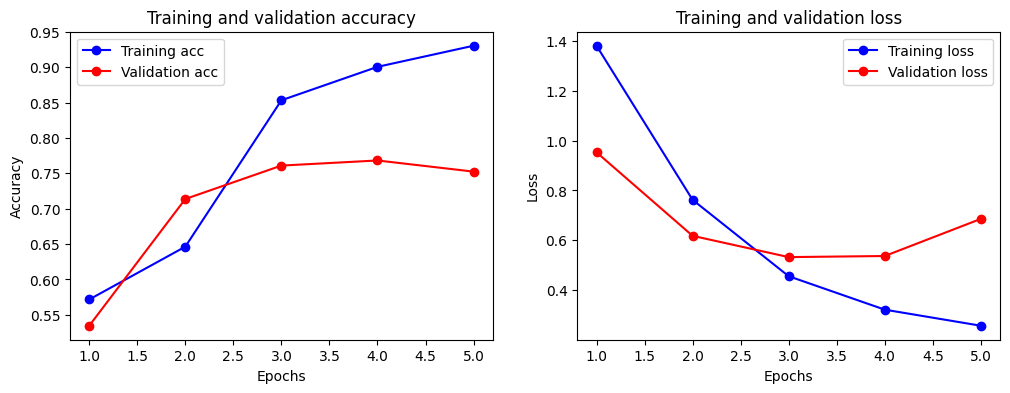

In [15]:
# Extract accuracy and loss values for training and validation
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### **Model 3 Results**

- Reduced Overfitting: Compared to the previous model, this model shows a reduced gap between training and validation accuracy, indicating that the measures taken to reduce overfitting have had some positive effect.

- Regularization Impact: The increased regularization has likely contributed to the lower starting accuracy but has helped in controlling the overfitting to some extent.

- Learning Effectiveness: The model shows effective learning over epochs, as seen in the steady increase in training accuracy.

- Early Signs of Overfitting: While the overfitting is less severe than in the previous model, it is still present, especially in the later epochs.

## **Step 5: Conclusion**
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Analyzing the results of the three models, we can draw several conclusions and learnings:

**Model 1:**
- High Training Accuracy: Achieved a training accuracy of 95.89%, indicating effective learning from the training data.
- Overfitting: Despite high training accuracy, the validation accuracy capped at 73.21%, showing a significant gap and suggesting overfitting.
- Takeaways: The basic LSTM structure was capable but may need adjustments, as indicated by the overfitting.

**Model 2:**
- Bidirectional LSTM and Increased Complexity: Introduced more complexity with Bidirectional LSTMs and additional dense layers.
- Slight Improvement in Validation Accuracy: A small improvement in validation accuracy to 74.79% but still significant overfitting.
- Takeaways: Additional complexity did not proportionally improve generalization. Batch normalization and increased model depth did not effectively address overfitting.

**Model 3:**
- Simpler Model Structure: Reduced LSTM units and layers, increased dropout and regularization to address overfitting.
- Reduced Overfitting but Lower Accuracy: Training accuracy reduced to 92.81%, and validation accuracy to 75.84%, showing a reduced gap and therefore less overfitting.
- Takeaways: Simplification and increased regularization helped in reducing overfitting. The balance between model complexity and the training data's variability became more apparent.

**General Learnings and Future Improvements:**

- Balancing Model Complexity: Overfitting is a key challenge, particularly with complex models. Balancing model complexity with the dataset's characteristics is crucial.
- Regularization and Dropout: Increasing dropout and regularization can mitigate overfitting but may lead to underfitting if overdone.
- Data Preprocessing and Augmentation: Experimenting with different preprocessing techniques or data augmentation could provide more robust features for the model to learn, potentially improving generalization.
- Hyperparameter Tuning: Systematic hyperparameter tuning could lead to finding a better configuration that balances training and validation performance.
- Alternative Architectures: Exploring different architectures like CNN-LSTM hybrids, Transformers, or simpler models based on the dataset size and complexity.
- Cross-Validation: Implementing k-fold cross-validation might provide a more stable estimate of model performance.

### **In summary, while increasing model complexity can improve training performance, it does not necessarily translate to better generalization. Simplifying the model and focusing on regularization strategies can help reduce overfitting. Continuous experimentation with model architecture, data processing, and hyperparameter tuning is key to finding the optimal balance**